In [12]:
import geopandas as gpd
import numpy as np
import pandas as pd
from rasterstats import zonal_stats
import rasterio  # For CRS checks
import matplotlib.pyplot as plt
import seaborn as sns
import ee

# Data Preperation

In [2]:
# Load parks boundaries
# The file 'Riyadh_parks_validated.geojson' should contain park boundaries sourced from OSM and validated against municipality points.
parks_gdf = gpd.read_file('Data/Riyadh_parks_validated.geojson')

# Check current CRS, it is often EPSG:4326 (WGS84 lat/long) from sources like OSM
current_crs = parks_gdf.crs
print("Current CRS:", current_crs)

# If not EPSG:20438, reproject for consistency
# EPSG:20438 is a projected system with meter units, essential for accurate metric calculations.
if current_crs != 'EPSG:20438':
    parks_gdf = parks_gdf.to_crs('EPSG:20438') #EPSG:20438 is UTM Zone 38N on the Ain el Abd 1970 datum, recommended for Saudi Arabia (including Riyadh) per official GEOSA guidelines[](https://epsg.io/20438).
    print("Reprojected to EPSG:20438")
else:
    print("Already in EPSG:20438")

# Confirm new CRS
print("Final CRS:", parks_gdf.crs)

# During validation done, based on script '01_ParksDataValidation.py' in Qgis, a new colm is added to hilight paarks that are under construction that should be not be considered
parks_gdf = parks_gdf[parks_gdf['Validation'] != 'Und-Cons']

Current CRS: EPSG:4326
Reprojected to EPSG:20438
Final CRS: EPSG:20438


# UGI related cooling factors calculations

## 1- Geometric Morphological Factors

This section calulates:
- UGI area in sqm
- UGI perimeter in m
- Landscape Shape Sndex (LSI) using the equ below as per  ([Cao et al., 2010](https://www-sciencedirect-com.libproxy.ucl.ac.uk/science/article/pii/S016920461000054X#fig1); [Shi et al., 2023](https://www-sciencedirect-com.libproxy.ucl.ac.uk/science/article/pii/S2210670723001300#sec0002)):

 $$LSI = \frac{P}{2\sqrt{\pi A}}$$

In [3]:
# Calculate area, perimeter, and LSI for each park
parks_gdf['area_m2'] = parks_gdf.geometry.area.round(2)
parks_gdf['perimeter_m'] = parks_gdf.geometry.length.round(2)
parks_gdf['LSI'] = (parks_gdf['perimeter_m'] / (2 * np.sqrt(np.pi * parks_gdf['area_m2']))).round(2)

In [7]:
print(parks_gdf[['area_m2', 'perimeter_m', 'LSI']].describe().round(2))

         area_m2  perimeter_m     LSI
count     225.00       225.00  225.00
mean    13528.50       402.15    1.21
std     32595.99       402.96    0.17
min       353.83        75.25    1.06
25%      2854.59       221.28    1.13
50%      4686.36       290.66    1.16
75%      8483.13       401.46    1.22
max    258129.69      3618.18    2.90


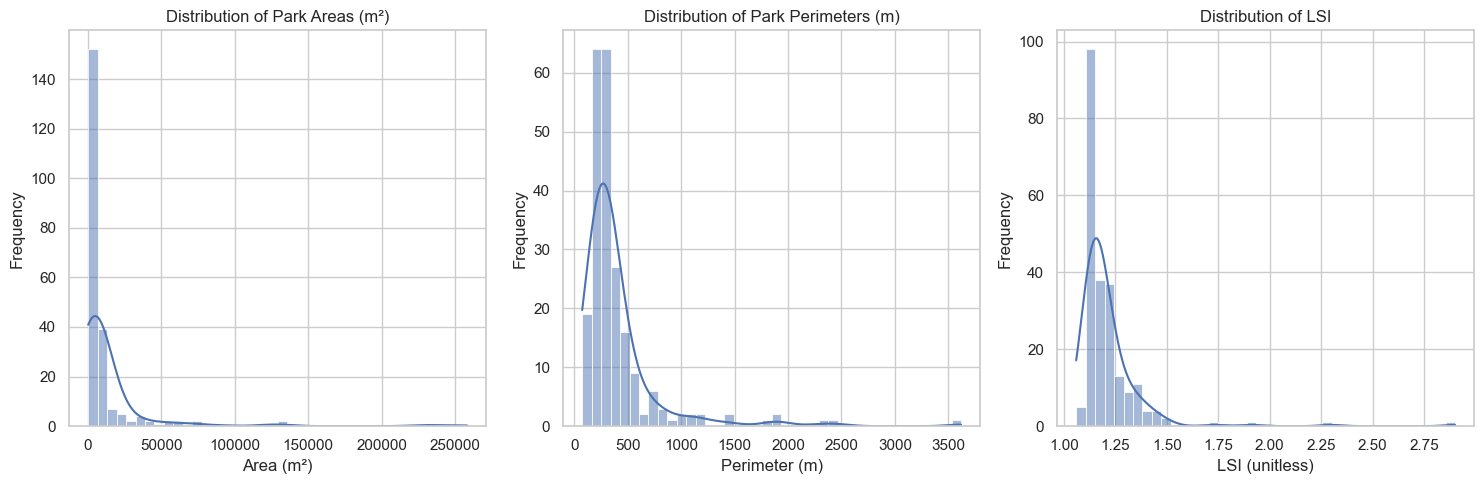

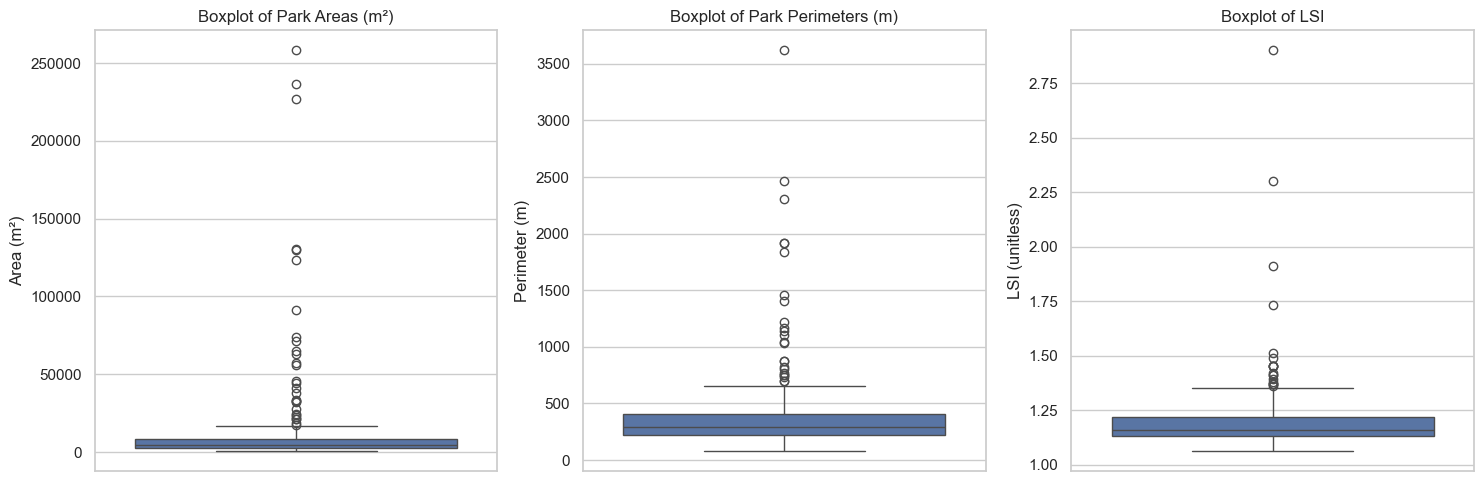

In [11]:
# Set plot style for better visuals
sns.set(style="whitegrid")

# Create subplots for histograms (distribution)
fig, axes = plt.subplots(1, 3, figsize=(15, 5))  # 1 row, 3 columns

# Histogram for Area
sns.histplot(parks_gdf['area_m2'], bins=40, kde=True, ax=axes[0])
axes[0].set_title('Distribution of Park Areas (m²)')
axes[0].set_xlabel('Area (m²)')
axes[0].set_ylabel('Frequency')

# Histogram for Perimeter
sns.histplot(parks_gdf['perimeter_m'], bins=40, kde=True, ax=axes[1])
axes[1].set_title('Distribution of Park Perimeters (m)')
axes[1].set_xlabel('Perimeter (m)')
axes[1].set_ylabel('Frequency')

# Histogram for LSI
sns.histplot(parks_gdf['LSI'], bins=40, kde=True, ax=axes[2])
axes[2].set_title('Distribution of LSI')
axes[2].set_xlabel('LSI (unitless)')
axes[2].set_ylabel('Frequency')

plt.tight_layout()  
plt.show()

# Boxplots for overview (medians, outliers)
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

sns.boxplot(y=parks_gdf['area_m2'], ax=axes[0])
axes[0].set_title('Boxplot of Park Areas (m²)')
axes[0].set_ylabel('Area (m²)')

sns.boxplot(y=parks_gdf['perimeter_m'], ax=axes[1])
axes[1].set_title('Boxplot of Park Perimeters (m)')
axes[1].set_ylabel('Perimeter (m)')

sns.boxplot(y=parks_gdf['LSI'], ax=axes[2])
axes[2].set_title('Boxplot of LSI')
axes[2].set_ylabel('LSI (unitless)')

plt.tight_layout()
plt.show()

## 2-  Factors


In [13]:
# Ensure Earth Engine to read NDVI data
# if this doesn't work, the tiff can be accessed here: https://drive.google.com/file/d/1tP0ABA_YqBJuB2yBi9bTWHk0-QwlYhUb/view?usp=drive_link
try:
    ee.Initialize(project='uss-dissertation')
except Exception:
    print("GEE initialization failed. Run ee.Authenticate() and try again.")
    ee.Authenticate()
    ee.Initialize(project='uss-dissertation')

In [ ]:
# The tiff can be accessed here: https://drive.google.com/file/d/1tP0ABA_YqBJuB2yBi9bTWHk0-QwlYhUb/view?usp=drive_link
ndvi_path = 'path/to/local/Riyadh_NDVI_2024.tif'  
with rasterio.open(ndvi_path) as ndvi_src:
    if ndvi_src.crs.to_string() != 'EPSG:20438':
        raise ValueError("NDVI CRS must match EPSG:20438. Reproject if necessary.")

In [ ]:



# Step 3: Zonal stats on rasters 
rasters = {
    'NDVI': 'path/to/NDVI_2024.tif',
    'NDISI': 'path/to/NDISI_2024.tif',
    'LST': 'path/to/LST_2024.tif'
}

# Function to get stats per raster
def get_zonal_stats(raster_path, gdf, prefix):
    stats = zonal_stats(gdf, raster_path, stats=['mean', 'min', 'max', 'std'], nodata=-999)  # Adjust nodata if needed
    stats_df = pd.DataFrame(stats)
    stats_df.columns = [f'{prefix}_{col}' for col in stats_df.columns]
    return stats_df

# Compute and merge stats
all_stats = pd.DataFrame()
for key, path in rasters.items():
    stats_df = get_zonal_stats(path, parks_gdf, key.lower())
    all_stats = pd.concat([all_stats, stats_df], axis=1)

# Combine with parks factors (assume 'park_id' or index for joining)
results_df = pd.concat([parks_gdf[['park_id', 'area_m2', 'LSI']], all_stats], axis=1)  # Adjust 'park_id' to your column

# Handle NDISI negatives: If < -1 due to calc issues, clip means to -1 (post-process)
results_df['ndisi_mean'] = results_df['ndisi_mean'].clip(lower=-1)

# Step 4: Export and basic analysis
results_df.to_csv('path/to/parks_analysis_2024.csv', index=False)
print(results_df.head())  # Preview

# Example correlation: Mean NDVI vs. LSI
corr = results_df['ndvi_mean'].corr(results_df['LSI'])
print(f"Correlation between mean NDVI and LSI: {corr:.2f}")